# Data Analytics and Data Mining

## Theoretical introduction
### Time series:

A time series is a set of data values observed in specific time intervals. They are typically used to describe phenomena that evolve over time. In the context of time series, time is a dependent variable. It is convenient to see a time series as a collection of successive points.  
#### Time series decomposition
In time series, it is possible to decompose the actual data in two main components, signal and noise i.e. error.
The simplest form of time series are the following:
- Additive:  
<h2>$Y_t = T_t + S_t + E_t$</h2>
- Multiplicative:  
<h2>$Y_t = T_t \times S_t \times E_t$</h2>  
- In general:  
<h2>$Y_t = f(T_t, S_t, E_t$)</h2>  
  
where $T_t$ is a trend factor which is used to model periodical time series i.e. cycles, $S_t$ is the seasonal information i.e. the data value regarding a particular time period, and $E_t$ is the error i.e. the noise measured in the data collection or confidence intervals to take into account for uncertanty.  
  
  In classical decomposition, it is useful to apply **Moving Average** (MA) to isolate the trend component and **Overall Average** to isolate the season component.  
  There are more advanced techniques e.g. **Locally estimated scatterplot smoothing** Regression (LOESS Regression) to mitigate the error within time series. 
  
#### LOESS Regression
It is possible to take into account a fraction of consecutive values (window) and try to fit a line i.e. weighted regression that best describe them. The best way to smooth is to identify a point of interest within the window and assign a weight to each point in the window such that the value that are closer (in time) to the interest point have a highest weight, and consequently, the further (in time) the values are from the interest point, the smaller is the weight attributed. By using this weighted linear regression, it is possible to fit a line and than consider only the predicted value correspondent to the point of interest. It is possible to apply this process iteratively considering every single point of the window as the point of interest. The resulting interception points are the smoothed values for that particular window. By shifting the window within the entire time series it is possible to compute the overall smoothed signal.

<img src="imgs/loess.png" />


#### Exponential Smoothing Models
The concept of time series underlies the assumption that data values in a certain time depend on previous observations. An **exponential smoothing model** is based on the fact that the influence on a certain point of previous values decrese exponentially over time. Given an instant of time $t$ and parameter $\theta$ s.t. $0 \leq \theta \leq 1$, the influence on a future (forecasted) value $\hat{Y}$ at time $t+1$ is:
<h2>$\hat{Y}_t = \theta Y_t + \theta (1 - \theta) Y_{t-1} + \theta (1 - \theta)^2 Y_{t-2} + \dots + \theta (1 - \theta)^n Y_{t-n}$</h2>
The larger is $\theta$, the more a value is directly influenced by its past. Finding a fitting $\theta$ allow to apply smoothing in a more significant way.

#### Calculate smoothing parameters
In a particular instant $t$, given an actual value $Y_t$ and a predicted value $\hat{Y}_t$, it is possible to find $\theta$ by minimising the sum of squares error ($SSE$):
<h2>$SSE = \sum_{t=1}^{T} (Y_t - \hat{Y}_t)$</h2>

#### Criticalities of this technique for forecasting
Given a series in a time interval such that time $t \in \mathbb{N}$ and $0 \leq t \leq T$, it is possible to apply the **exponential smoothing model** for predicting value at time $t = T+1$, with the optimal $\theta$, but the future forecasted values will have the same value (because of optimal $\theta$) as value in $t = T+1$. So value in $t = T+2$ will be equal to the value in $t = T+1$ and so on. This method will always produce a flat line as a forecast.  **Exponential smoothing model** is able to produce forecast in $t = T+1$ only.

<img src="imgs/exponential-forecasting.png" width="50%" />
  
The predicted value in $t = T+1$ is called __level__ ($L_t$) and is one of the components of the forecast.

#### Forecast components
A forecast $\hat{y}$ can be seen as a composition of depending factors. Given a time unit $k$, a future value $\hat{Y}_{T + k}$ has the following components:

<h2>$\hat{y}_t+k = L_{t} + kT_t + S_{t-p+k}$</h2>
  
where:
<h2>$L_{t} = \theta Y_t + (1 - \theta) L_{t-1} \text{ i.e. Level}$</h2>
<h2>$T_{t} = \gamma (L_t - L_{t-1}) + (1 - \gamma)T_{t-1} \text{ i.e. Trend}$</h2>
<h2>$S_{t} = \delta (Y_t - L_t) + (1 - \delta) S_{t-p} \text{ i.e. Season}$</h2>
  
The Trend $T_t$ is meant to forecast future values using the **Holt exponential smoothing model**, while the effect of seasons (periodicity in a time interval) is modeled by the **Winter exponential smoothing model**. The linear combination of the three models is called **Triple exponential smoothing model**.

#### Stationarity
All values of a time series are time dependent by definition, hence is not possible to have independence. Nevertheless is still possible to measure consistency of a time series. In time series it is possible to analyse a frame (window) and measure the distribution of values in that specific time period. For different window width, it is expected a different distribution. For equally large windows it is expected the same data distribution. If this property is satisfied, the time series is called **consistent**.

<img src="imgs/different-time-frames.PNG" width="60%" />
<img src="imgs/equal-time-frames.PNG" width="60%" />

For consistent time series, the window width is not important as soon as we consider equaly large frames.
If a series is consistent, it has the property of **Strong Stationarity**. If in two equally large time frame it is observed a difference between distribution, but nevertheless the two frames distribution have similar **Mean, variance**, or **autocorrelation**, the time series has **Weak Stationarity**.   
Note: even though a time series present **strong stationarity** this does not imply that the series has also **weak stationarity** as the weak stationarity needs to have finite variance, while strong stationarity, in general, does not (be carefull with definition that can be misleading).  

Not all time series satisfy stationarity, a classical way to overcome this problem is **Differencing**. To do so, it is just needed to compute the difference between values belonging of different equally large windows.

<img src="imgs/differencing.PNG" width="100%" />

If data are **seasonal** it is possible to introduce the effect of the season and compute the difference between data of the previous season $S$: $Y_t - Y_{t-S}$.

<img src="imgs/season.PNG" width="100%" />

### Auto Regressive (AR) models
In the field of stationary series (only), it is possible to build models for forecasting future values using solely past i.e. historical data. The past values in the time series are called **Lags**. An autoregressive model which consider only lags can be described by the following eq. 1:

<h2>$Y_t = \omega + \phi Y_{t-1} + \epsilon_t $</h2>

where $Y_t$ is the target variable, $Y_{t-1}$ is the **lagged target**, $\epsilon$ is the error, $\omega$ and $\phi$ are the interceptor and the coefficient, respectively.  

The lagget target $Y_{t-1}$ allows to model the time dependency with past values (eq. 2).
<h2>$Y_{t-1} = \omega + \phi Y_{t-2} + \epsilon_{t-1} $</h2>  

This concept can be generalized by putting together equations 1 and 2.
<h2>$Y_t = \frac{\omega}{1-\phi} + \phi^t Y_1 + \phi^{t-1} \epsilon_2 + \phi^{t-2}\epsilon_3 + \dots + \epsilon$</h2>  

The point is that the coefficient $\phi$ of stationary time series is such that $|\phi| < 1$, hence, although minimal, $Y_1$ influence $Y_t$ with an exponentially weaker affect (Note: That's why Exponential Smoothing Models). So for non stationary time series $|\phi| \geq 1$.  

Autoregressive models can be more accurate (and more complex) by considering not only the effects of previous lags $t-1$ but generally considering an arbitrary long effect $t-p$. Simple autoregression is of order one, i.e. AR(1), while more complex autoregression models of order $p$ can be expressed with the notation AR(p) and described by the following:

<h2>$Y_t = \omega + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots + \phi_p Y_{t-p} + \epsilon_t$</h2>

<img src="imgs/lags.PNG" width="60%" />


### Moving Average (MA) models

It is also possible to forecast a series basing solely on the **past errors** (instead of considering past values), that are typically called **lagged errors**. In this case a forecast is described by the following:

<h2>$ Y_t = \omega + \theta \epsilon_{t-1} + \epsilon_t$</h2>  
  
  In this case, $e_{t-1}$ is the lagged error term.

<img src="imgs/lagged-error.PNG" width="60%" />
  
MA models are called short memory models because the impact of the error is does not perpetuate for long in the future. Similarly to the concept of stationarity (which implies the effect of previous data value to be less effective going ahead in time), the effect of error completely disappear going forward in time.
  
The main difference between AR models and MA models is that in AR models the effect of past data values slowly decrease going forward in time, while for MA models the effect of past errors disappear completely.
  
In MA models it is possible to consider lagged errors coming from a number $q$ of past time units.

### Auto Regressive Integrated Moving Average (ARIMA) Models

AR models (long memory models) and MA (short memory models) are related and hence can be combined together.
Considering a number of lags $p$ and a number of error lags $q$, it is possible to consider a ARMA model. By differencing the long memory contributions and the short memory contributions it is possible to introduce a parameter $d$ such that ARIMA(p, d, q):
<h2>
\begin{equation}
    \begin{cases}
      Y_t - Y_{t-1} - \dots - Y_{t-p} = W_t \\
      W_t = \omega + \phi_1W_{t-1} + \theta_1 \epsilon_{t-1} + \dots + \phi_qW_{t-q} + \theta_q \epsilon_{t-q} + \epsilon_t
    \end{cases}\
\end{equation}
</h2>  
To summarize it is possible to state that $p$ is the number of AR terms, $d$ is the number of first differencing, and $q$ is the number of MA terms.

### Seasonal ARIMA models
Seasonal data are not stationary by definition. For a seasonality $S$ (periodicity of data), it is possible to difference the series as $Y_t - Y_{t-S}$. It is now possible to add seasonality terms to the model ARIMA(p, d, q)(P, D, Q)s where:  
 - $p, d, q$ are the traditional ARIMA terms
 - $P$ is the number of seasonal AR terms
 - $D$ is the number of seasonal differences
 - $Q$ is the number of seasonal MA terms
 - $s$ is the length of the season
  
Note: optimal values of $d$ and $D$ are usually the smallest number of differencing required to make the series stationary.

## The effects of weather on agricoltural commodity price predictions

In [1]:
#Pip Packages
#!pip install pmdarima
#!pip install statsmodels==0.11.0

#Imports and settings
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib.dates
from datetime import datetime
import scipy.stats as stats
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf #Metrics
import pmdarima as pm #Auto arima
from loess import loess_1d

#Settings
%config InlineBackend.figure_format='retina'

### Retrieve data from a private remote server

In [2]:
remote_host = 'https://www.ingmarzo.it/data/'
corn_data = pd.read_csv(remote_host + 'corn-data.csv', header=8, parse_dates=['date'], index_col='date')
soybean_data = pd.read_csv(remote_host + 'soybean-data.csv', header=8, parse_dates=['date'])
weather_data = pd.read_csv(remote_host + 'weather-data.csv', header=0, parse_dates=['DATE'])

## Data Cleaning

In [3]:
corn_data.rename(columns={' value': 'value'}, inplace=True) #bug on value fixed
weather_data.rename(columns={'DATE': 'date'}, inplace=True) #rename date column
corn_data.index = pd.to_datetime(corn_data.index)  

start_date, end_date = '1975-01-01', '1978-01-01'
corn_date_filter = (corn_data.index > start_date) & (corn_data.index <= end_date)

corn_data_filter_date = corn_data.loc[corn_date_filter]

### Downsampling

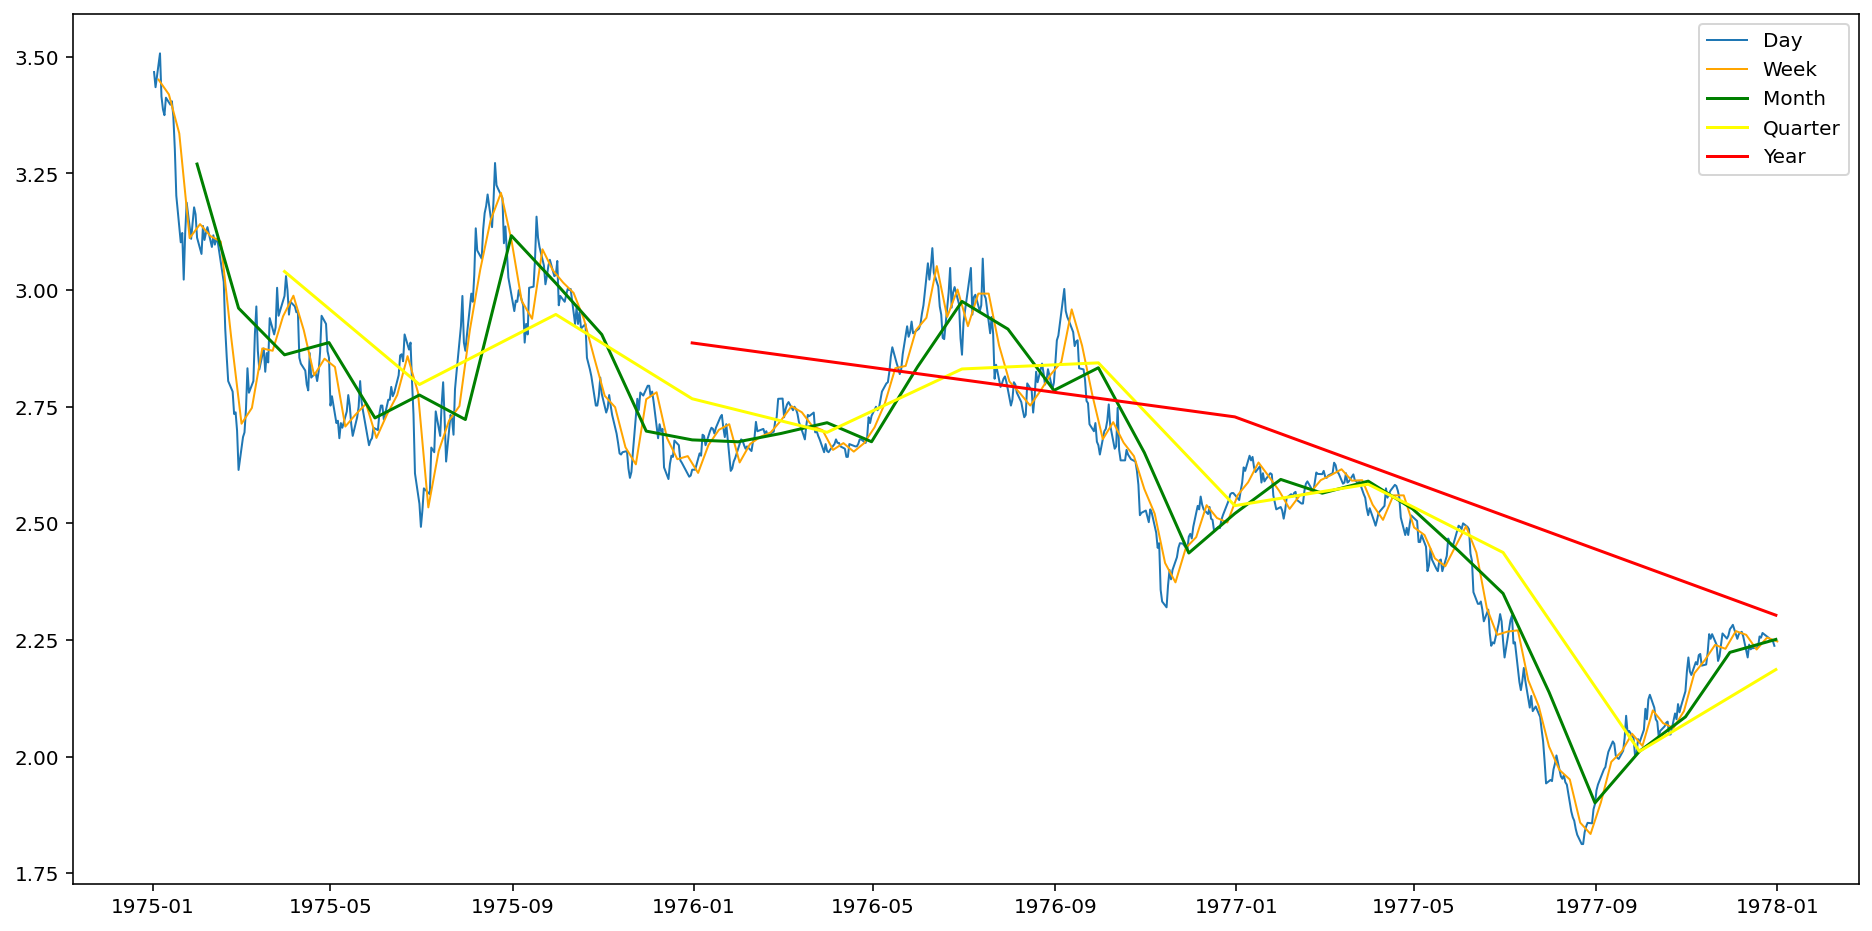

In [4]:
corn_data_clean_week = corn_data_filter_date.resample('W').mean()
corn_data_clean_month = corn_data_filter_date.resample('M').mean()
corn_data_clean_quarter = corn_data_filter_date.resample('Q').mean()
corn_data_clean_year = corn_data_filter_date.resample('Y').mean()

#Uncomment the most suitable for corn data
#resample_period, resample_label = 365, 'D'
resample_period, resample_label = 52, 'W'
#resample_period, resample_label = 12, 'M'
#resample_period, resample_label = 3, 'Q'
#resample_period, resample_label = 1, 'Y'

corn_data_clean = corn_data_filter_date.resample(resample_label).mean()

plt.rcParams.update({'figure.figsize':(16,8)})

#plt.plot(yout)
plt.plot(corn_data_filter_date['value'], linewidth=1, label='Day')
plt.plot(corn_data_clean_week['value'], color='orange', linewidth=1, label='Week')
plt.plot(corn_data_clean_month['value'], color='green', label='Month')
plt.plot(corn_data_clean_quarter['value'], color='yellow', label='Quarter')
plt.plot(corn_data_clean_year['value'], color='red', label='Year')
plt.legend()


plt.show()
#corn_data_clean

### Smoothing to mitigate the error
Time series decomposition can be Additive or multiplicative, we test the residual error for normality to understand the best decomposition method.

In [5]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# additive seasonal component
result_add = seasonal_decompose(corn_data_clean['value'],  
                                model='additive', 
                                extrapolate_trend='freq')

# multiplicative seasonal component
result_mul = seasonal_decompose(corn_data_clean['value'],  
                                model='multiplicative', 
                                extrapolate_trend='freq')

def norm_test(residuals, label='Data'):
    #perform Chi-Square Goodness of Fit Test
    #H0: residual error follows normal distribution
    #H1: residual error does not follow normal distribution
    sample_size = min(100, len(residuals))
    hyp_test = stats.normaltest(residuals.sample(sample_size, random_state=19).values)
    res = f'{label} does ' + ('' if hyp_test[1] > 0.05 else 'not ') +\
            f'follow the normal distribution, p-value: {hyp_test[1]}'
    print(f'{label} variance: {np.var(residuals)} \
            mean: {np.mean(residuals)}')
    print(res)
    
def show_density(residuals, label='Data', bins = 20):
    sns.displot(residuals, kde=True, 
             bins=int(len(residuals)/bins), color = 'blue')
    plt.show()
    
norm_test(result_add.resid, 'Additive residual error')
norm_test(result_mul.resid, 'Multiplicative residual error')

Additive residual error variance: 0.027636063013408443             mean: 0.017073344306322104
Additive residual error does follow the normal distribution, p-value: 0.43591174386666753
Multiplicative residual error variance: 0.004115662669652745             mean: 1.0059741678067142
Multiplicative residual error does follow the normal distribution, p-value: 0.30306854774124925


#### Empirical evaluation
the time series seem to be composed by additive components

In [6]:
def show_decomposition(decomp_result, title=''):
    fig, ax = plt.subplots(3,1)
    fig.suptitle(title, fontsize=16)
    ax[0].plot(decomp_result.trend, label='Trend')
    ax[1].plot(decomp_result.seasonal, label='Seasonal')
    ax[2].plot(decomp_result.resid, label='Error')
    ax[0].title.set_text('Trend')
    ax[1].title.set_text('Seasonal')
    ax[2].title.set_text('Error')
    ax[0].axes.xaxis.set_ticklabels([])
    ax[1].axes.xaxis.set_ticklabels([])
    plt.show()

### Visualize Decompositions

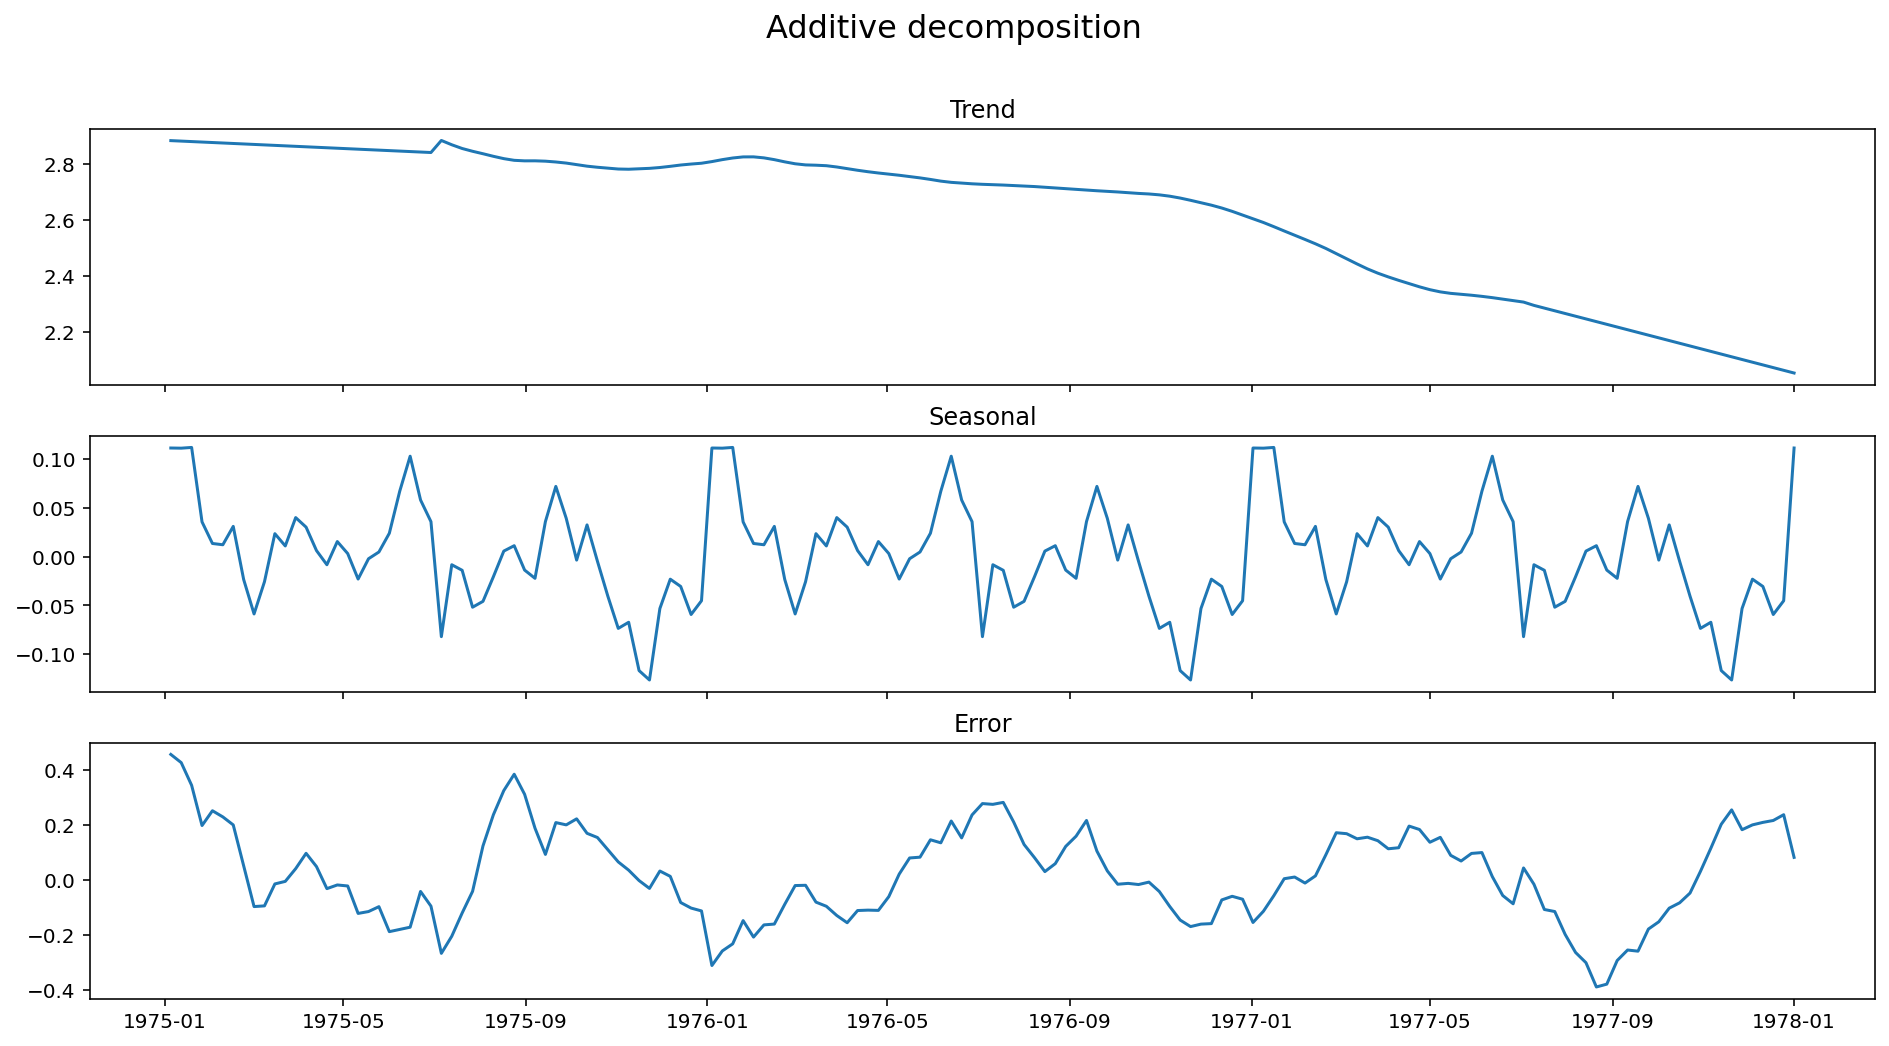

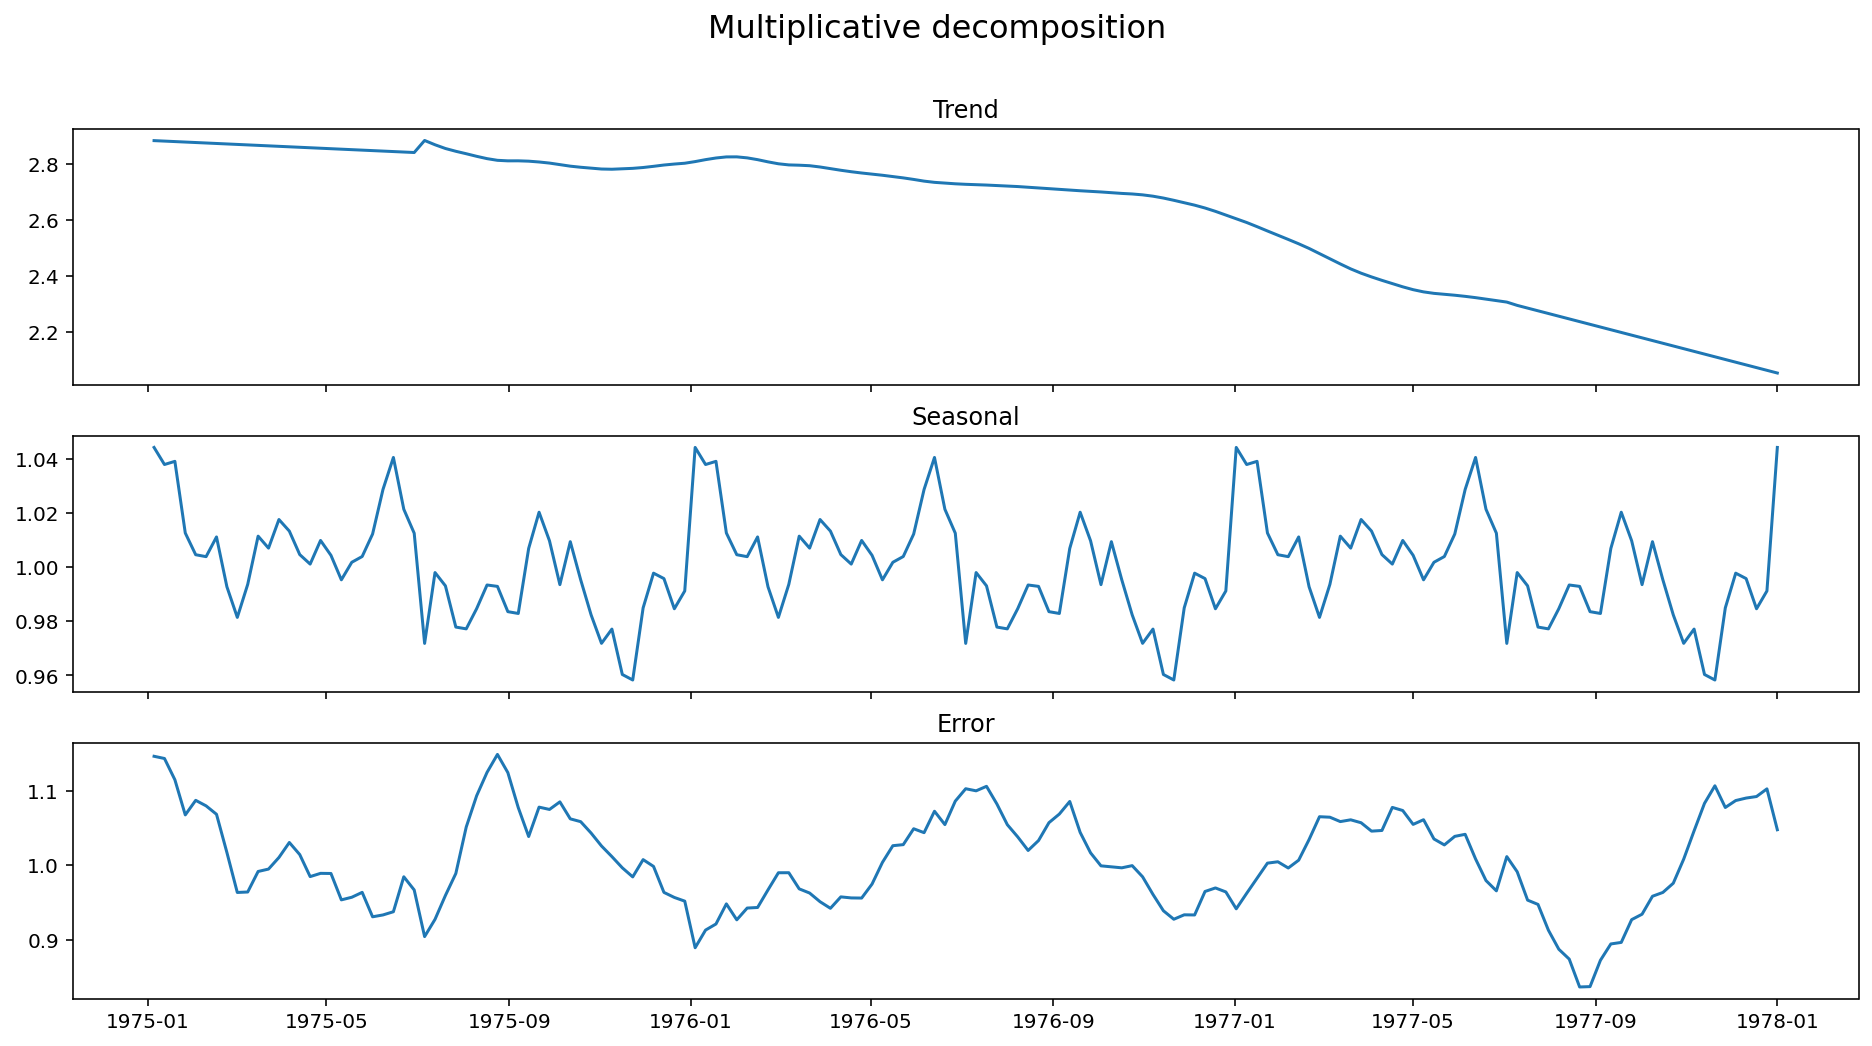

In [7]:
show_decomposition(result_add, 'Additive decomposition')
show_decomposition(result_mul, 'Multiplicative decomposition')

### Visualize residual error density

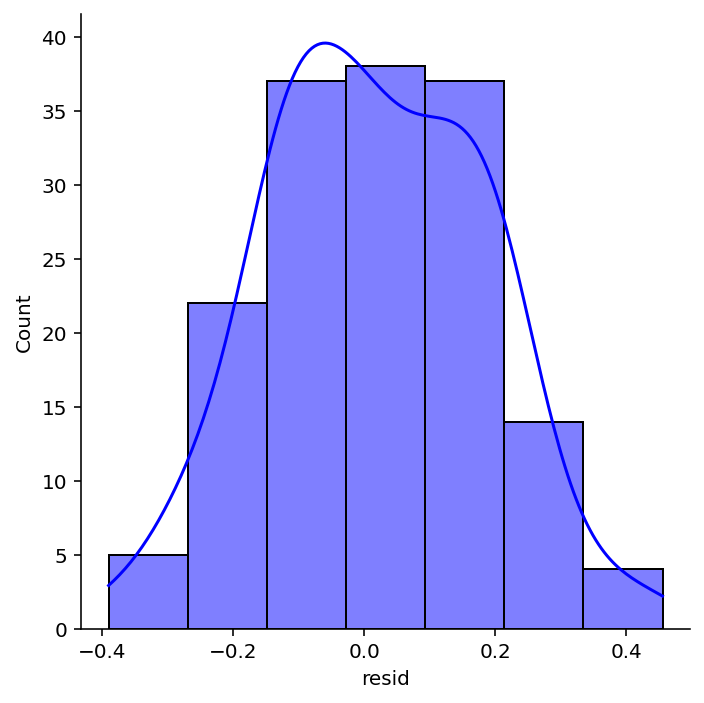

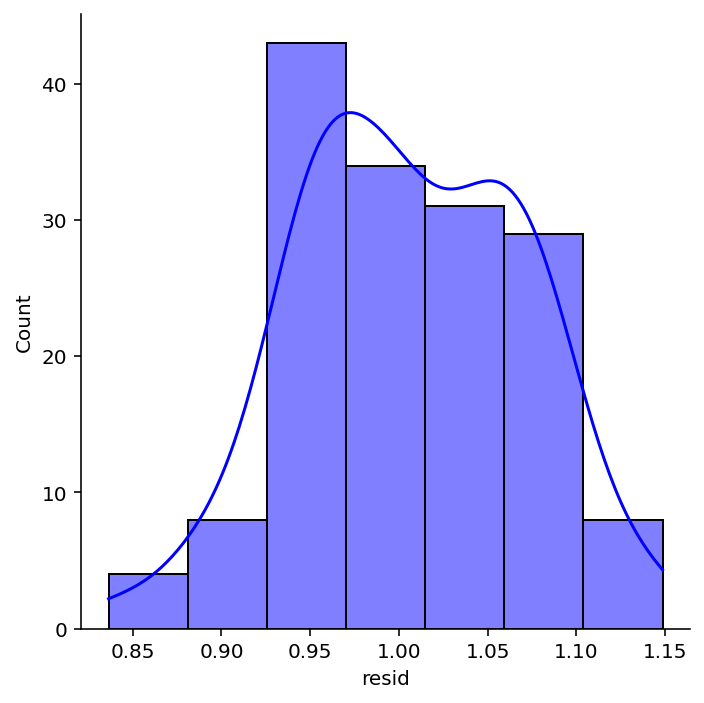

In [8]:
show_density(result_add.resid)
show_density(result_mul.resid)

## Data exploration conclusions
It will be considered an additive composition and residual error will be removed.

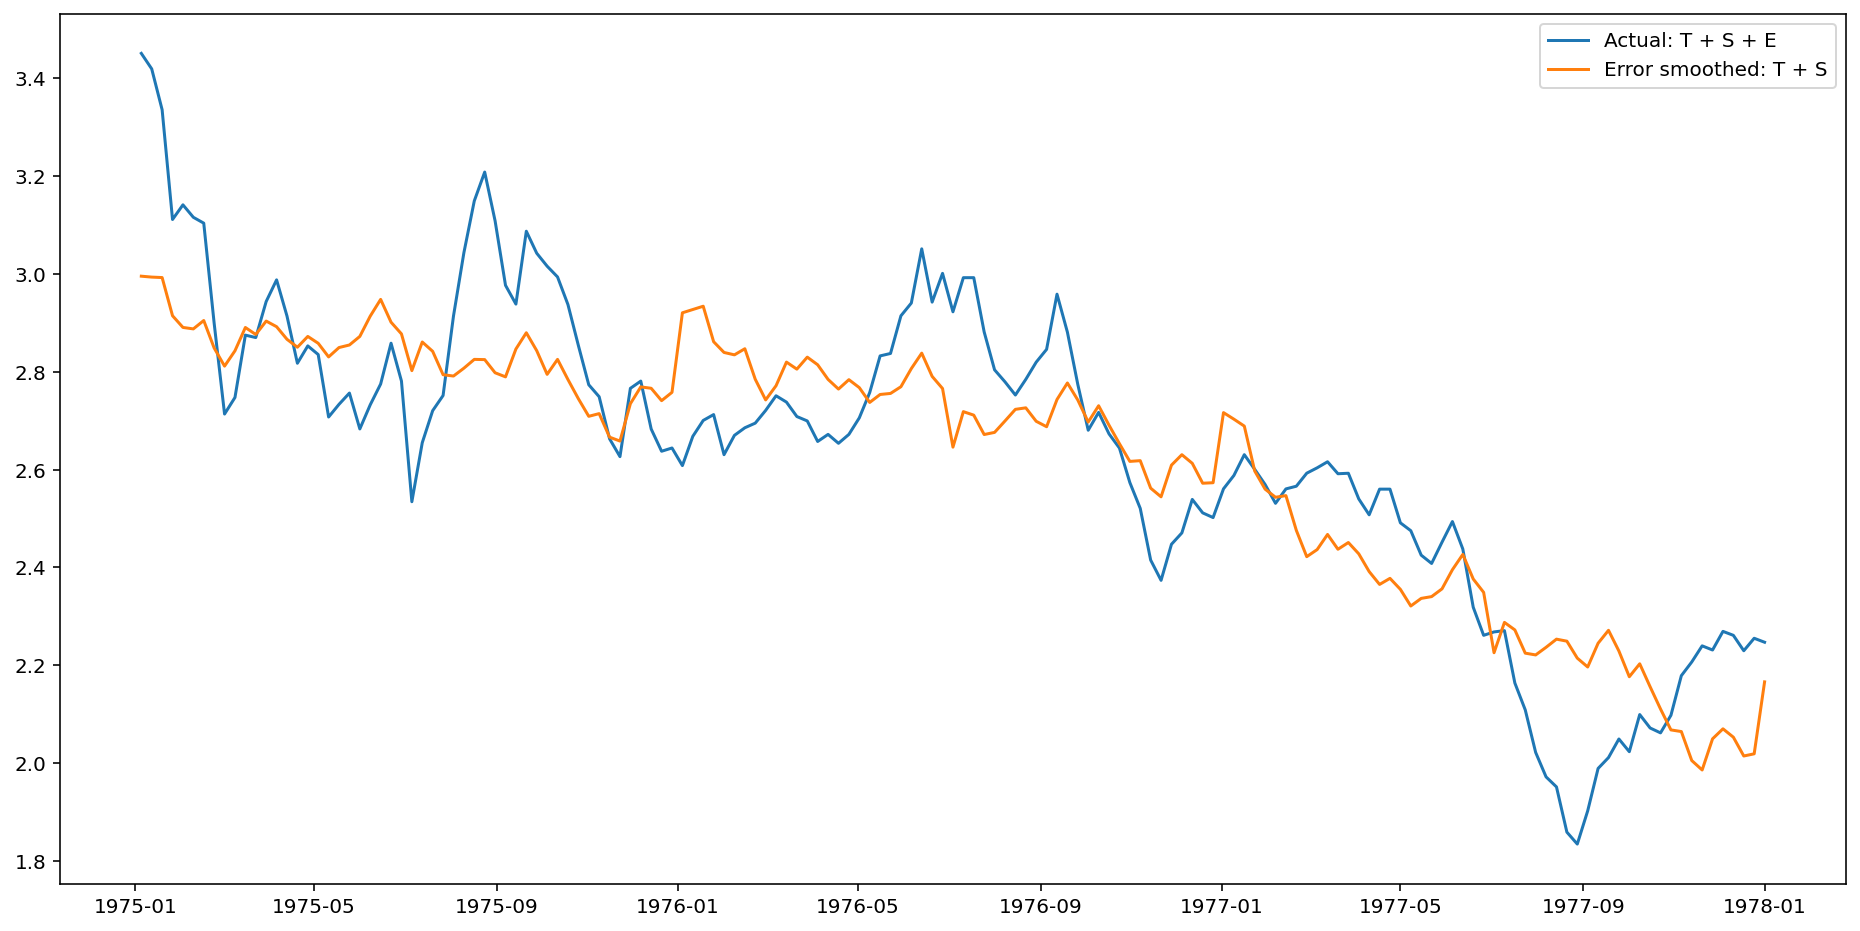

In [9]:
plt.plot(corn_data_clean, label='Actual: T + S + E')
corn_data_clean_ne = result_add.trend + result_add.seasonal
plt.plot(corn_data_clean_ne, label='Error smoothed: T + S')
plt.legend()
plt.show()

In [10]:
corn_data_clean['value'] = corn_data_clean['value'] - result_add.resid
corn_data_clean

,value
date,
1975-01-05,2.995548
1975-01-12,2.993681
1975-01-19,2.992733
1975-01-26,2.914614
1975-02-02,2.890737
...,...
1977-12-04,2.069801
1977-12-11,2.052676
1977-12-18,2.014215


## Univariate Time Series Forecasting
Use only the past values of the time series to predict its future values.

---


**ARIMA** i.e. Auto Regressive Integrated Moving Average, is a class of models that analyses a time series based on its own previous values and can be used to anticipate future values. 

### Auto regressive (AR) Analysis
To avoid the effect of inter-dependency it is possible to apply differentiation and make the series Stationary. The  Augmented Dickey Fuller test (ADF test) tests the hypothesis of autocorrelation of a series. 

In [11]:
# Is the series autocorrelated i.e. not stationary?
#H0: the series is autocorrelated i.e. not stationary
#H1: the series is stationary
# ADF Test
result = adfuller(corn_data_clean.dropna())
significance_value = 0.05
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('The time series ' + ('is' if result[1] > significance_value else 'is not') + ' auto-correlated')

ADF Statistic: 2.296365
p-value: 0.998953
The time series is auto-correlated


### Test results
Since P-value is greater than the significance level, the series is autocorrelated (as expected). It is now possible to differentiate the series and repeat the ADF Test

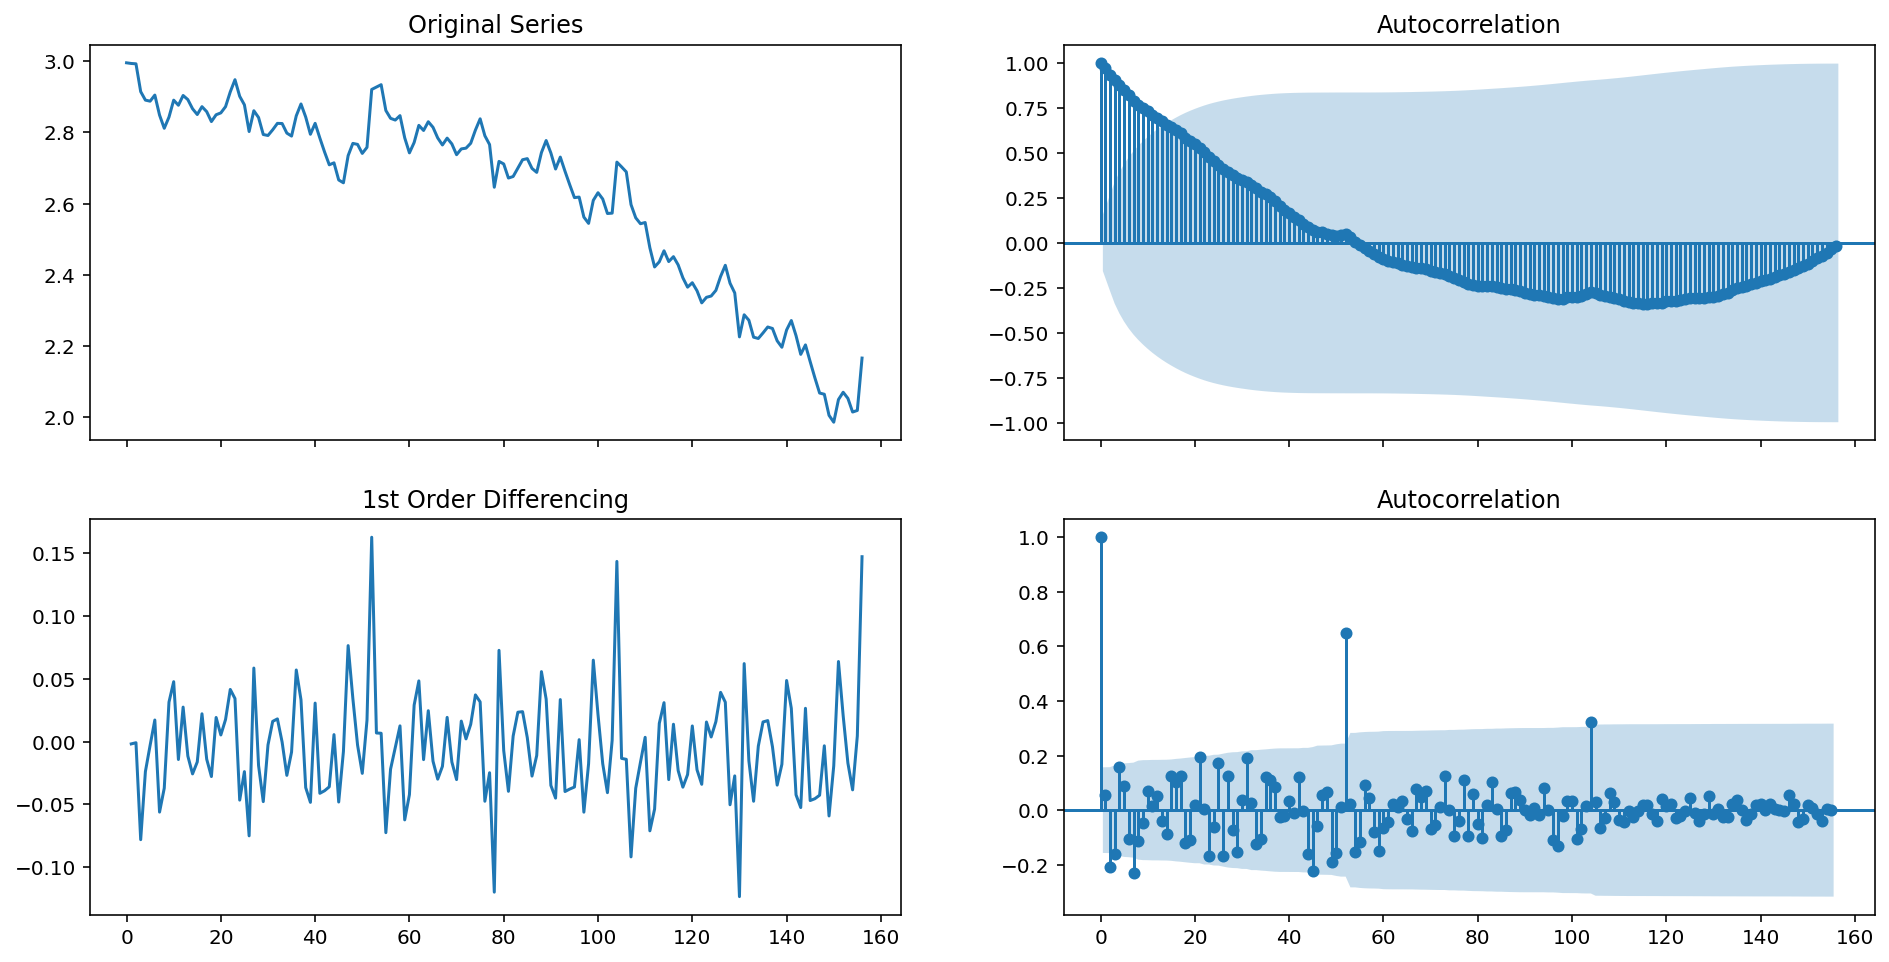

In [12]:
plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2, sharex=True)
axes[0, 0].plot(corn_data_clean['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = corn_data_clean['value'].values
lags_n = len(series_data) - 1
plot_acf(series_data, ax=axes[0, 1], lags=lags_n)

# 1st Differencing
axes[1, 0].plot(corn_data_clean['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = corn_data_clean['value'].diff().dropna().values
first_diff_lags_n = len(first_diff_series) - 1
plot_acf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n)

plt.show()

In [13]:
# Test autocorrelation for 1st order differencing
result = adfuller(corn_data_clean['value'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.427050
p-value: 0.000000


### Corn price is no longer autocorrelated
The resulting series `corn_data_clean['value'].diff()` has been proven stationary

In [14]:
#corn_data_clean['value'].diff().values

### Partial autocorrelation
Many values can be still partially autocorrelated, the PACF plot gives a visual hint about how resudual partial autocorrelation is present in the data. Since many values resides within the lightblue region (Significance limit region) the effect of autocorrelation is well contained. Values outside of the lightblue region are the most affected by autocoreelation

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


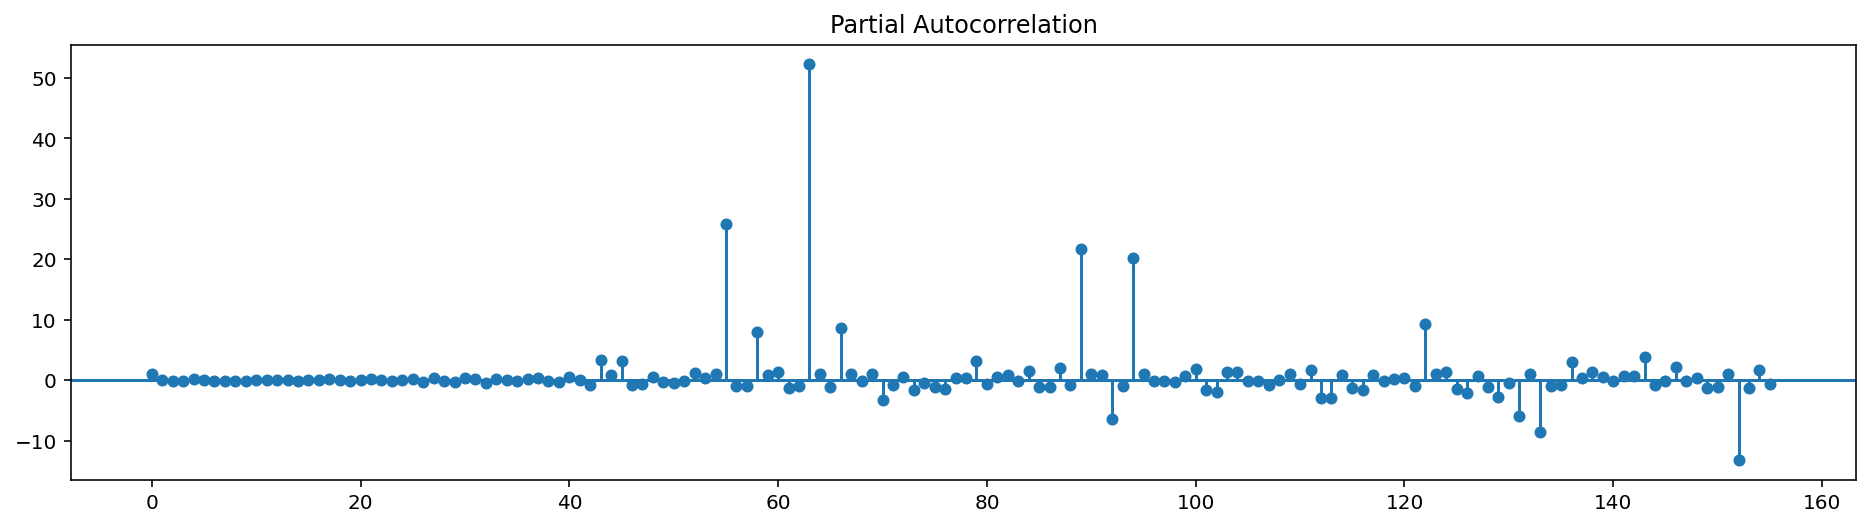

In [15]:
plt.rcParams.update({'figure.figsize':(16,4)})
fig, axes = plt.subplots(1, 1, sharex=True)
series_data = corn_data_clean['value'].diff().dropna()
lags_n = len(series_data) - 1
plot_pacf(series_data, ax=axes, lags=lags_n)
plt.show()

## Import and set up ARIMA Model

In [16]:
#ARIMA Model
model = ARIMA(corn_data_clean['value'].dropna().values, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  156
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 273.766
Method:                       css-mle   S.D. of innovations              0.042
Date:                Tue, 05 Apr 2022   AIC                           -539.532
Time:                        16:57:52   BIC                           -527.332
Sample:                             1   HQIC                          -534.577
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0052      0.004     -1.446      0.148      -0.012       0.002
ar.L1.D.y     -0.2772      0.306     -0.906      0.365      -0.877       0.322
ma.L1.D.y      0.3838      0.285      1.345      0.1

### Visualize residual errors

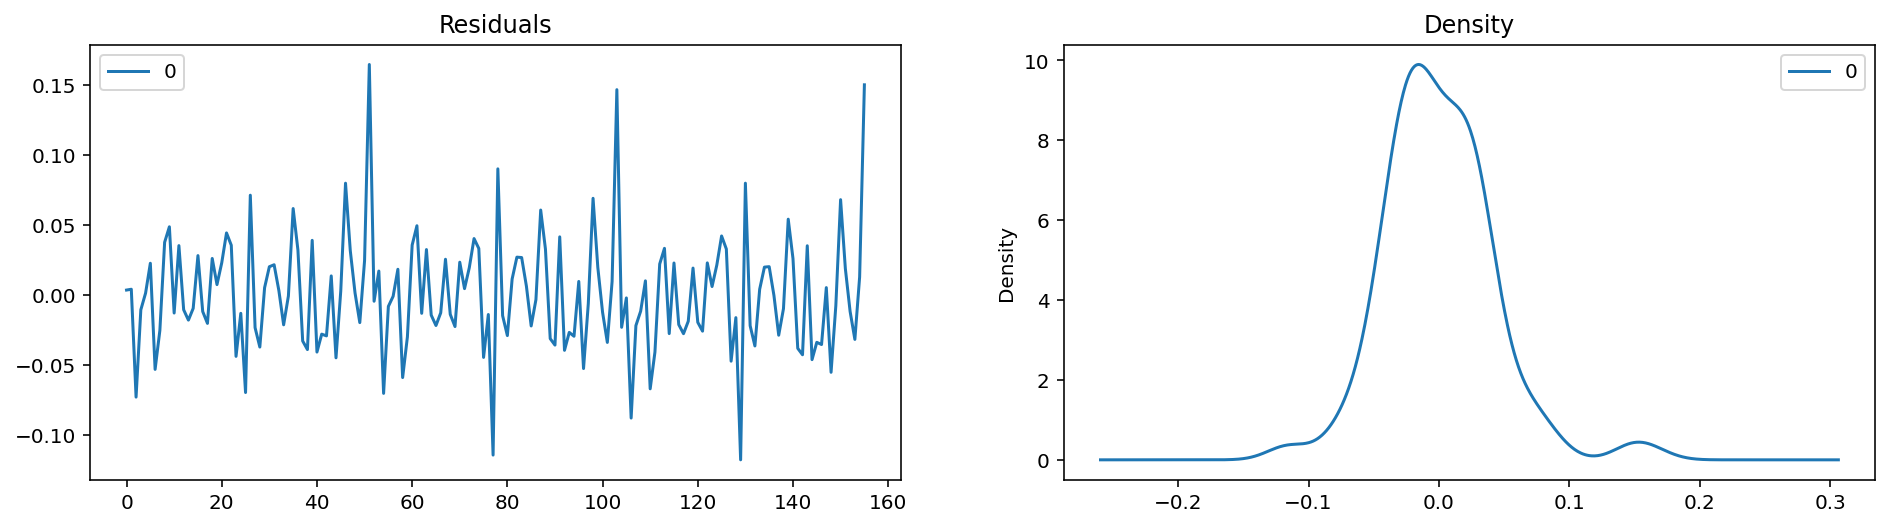

In [17]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Is the error consistent?
Test if residual errors follow normal distribution

In [18]:
import scipy.stats as stats

#perform Chi-Square Goodness of Fit Test
#H0: residual error follows normal distribution
#H1: residual error does not follow normal distribution
sample_size = min(100, len(residuals))
hyp_test = stats.normaltest(residuals.sample(sample_size, random_state=19).values)
res = 'Price difference does ' + ('' if hyp_test[1] > 0.05 else 'not ') +\
        f'follow the normal distribution, p-value: {hyp_test[1]}'
print(f'Residuals variance: {np.var(residuals).values} \
        mean: {np.mean(residuals).values}')
print(res)

Residuals variance: [0.00175063]         mean: [4.10310332e-06]
Price difference does not follow the normal distribution, p-value: [0.00731942]


### Plot actual vs predicted values

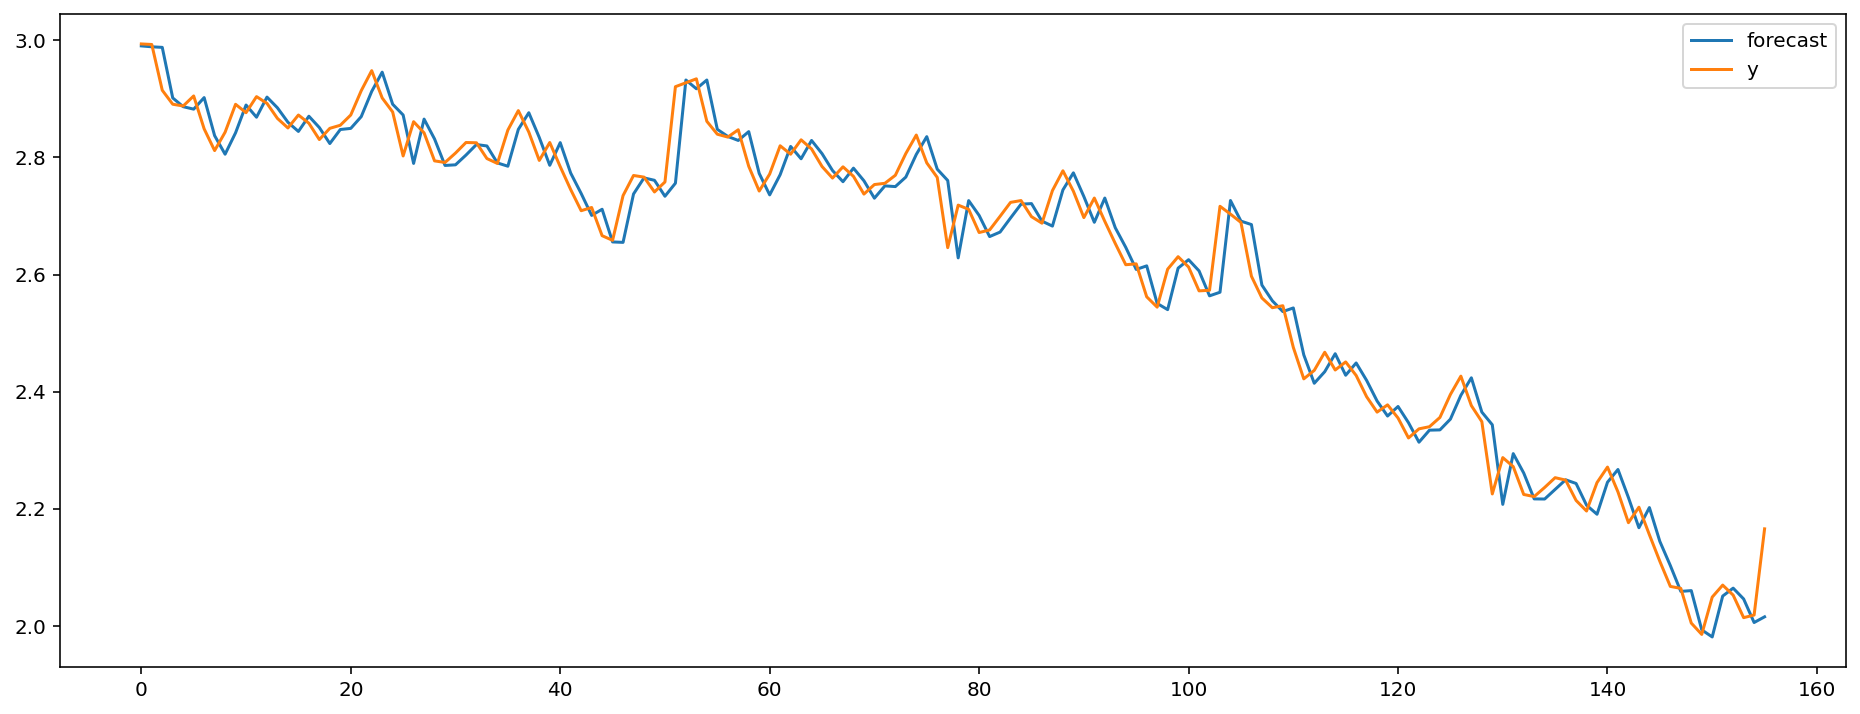

In [19]:
plt.rcParams.update({'figure.figsize':(16,6)})
model_fit.plot_predict(dynamic=False)
plt.show()

## Out-of-time ARIMA validation
In order to tune the model to predict unseen prices it is possible to split the actual dataset in train (75%) and test (25%) subsets.  
It is then possible to fit ARIMA model with the training test and compare predicted results with test set.

In [20]:
perc_split = .9
corn_data_split = round(len(corn_data_clean) * perc_split)
corn_data_train = corn_data_clean.iloc[0:corn_data_split]
corn_data_test = corn_data_clean.iloc[corn_data_split:]

### Plot predictions

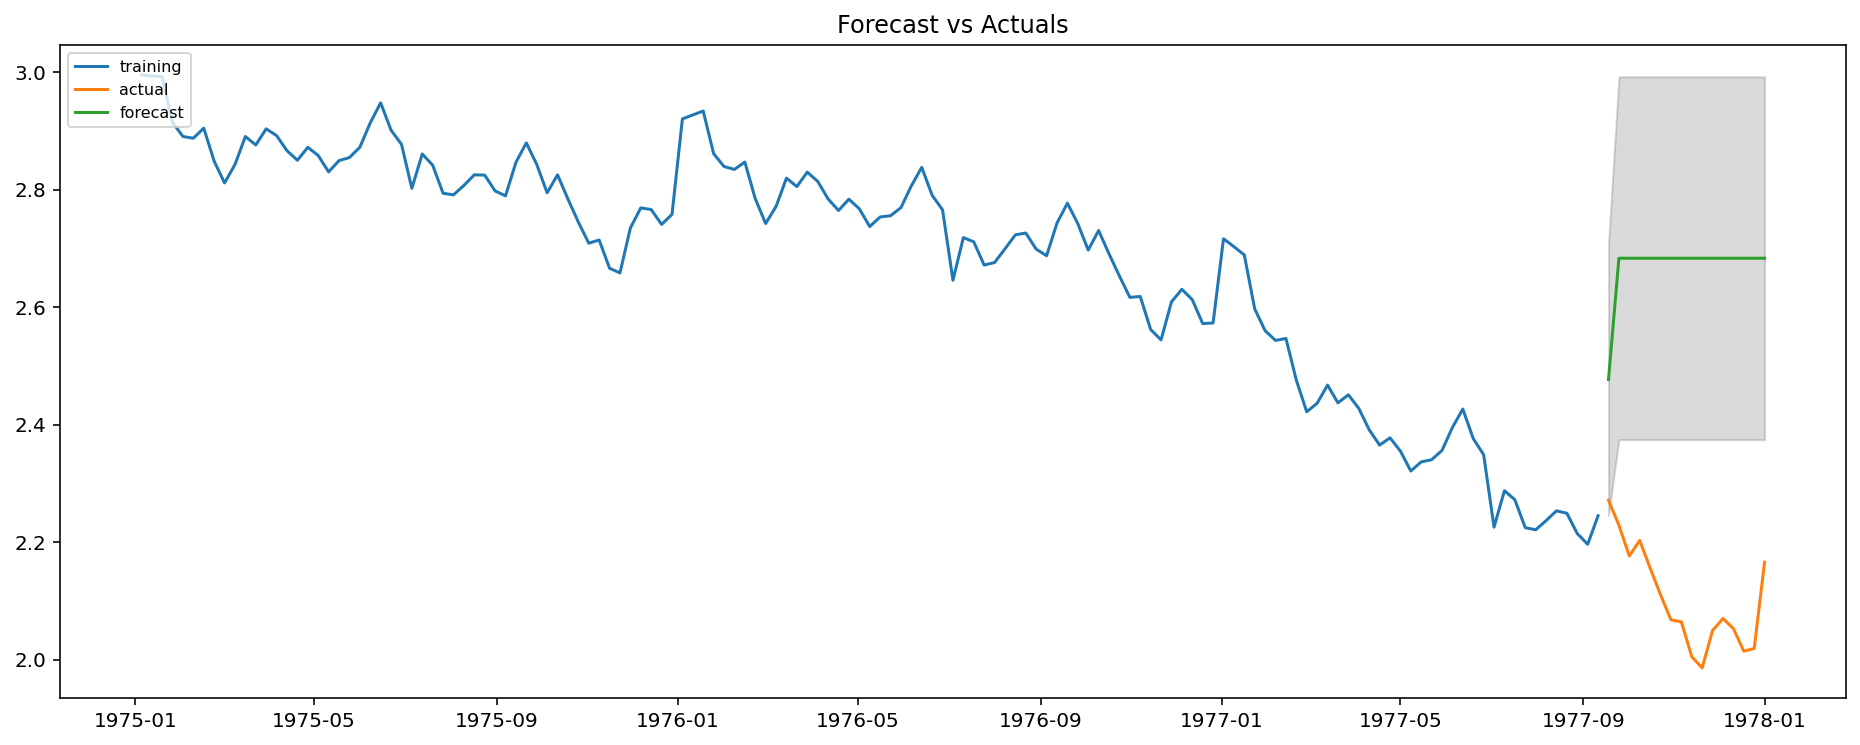

In [21]:
model = ARIMA(corn_data_train['value'].dropna().values, order=(0, 0, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(corn_data_test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=corn_data_test['value'].index)
lower_series = pd.Series(conf[:, 0], index=corn_data_test['value'].index)
upper_series = pd.Series(conf[:, 1], index=corn_data_test['value'].index)

# Plot
plt.rcParams.update({'figure.figsize':(16, 6)})
plt.plot(corn_data_train['value'], label='training')
plt.plot(corn_data_test['value'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Empirical evaluation
Results are inconsistent with actual data since the majority of results are below the actual price. This lead to find best arima parameters to train a more precise model.

In [22]:
model = pm.auto_arima(corn_data_train['value'].dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

#print(model.summary())
model.aic()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-496.132, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-494.618, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-492.907, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-493.076, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-494.218, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-493.669, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-498.560, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-495.078, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-500.615, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-497.061, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-496.881, Time=0.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-498.544, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-498.186, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-496.104, Time=0.60 sec
 ARIMA(2,1,2)(0,0,0)[0]          

-502.72912925120636

## Plot ARIMA diagnostic

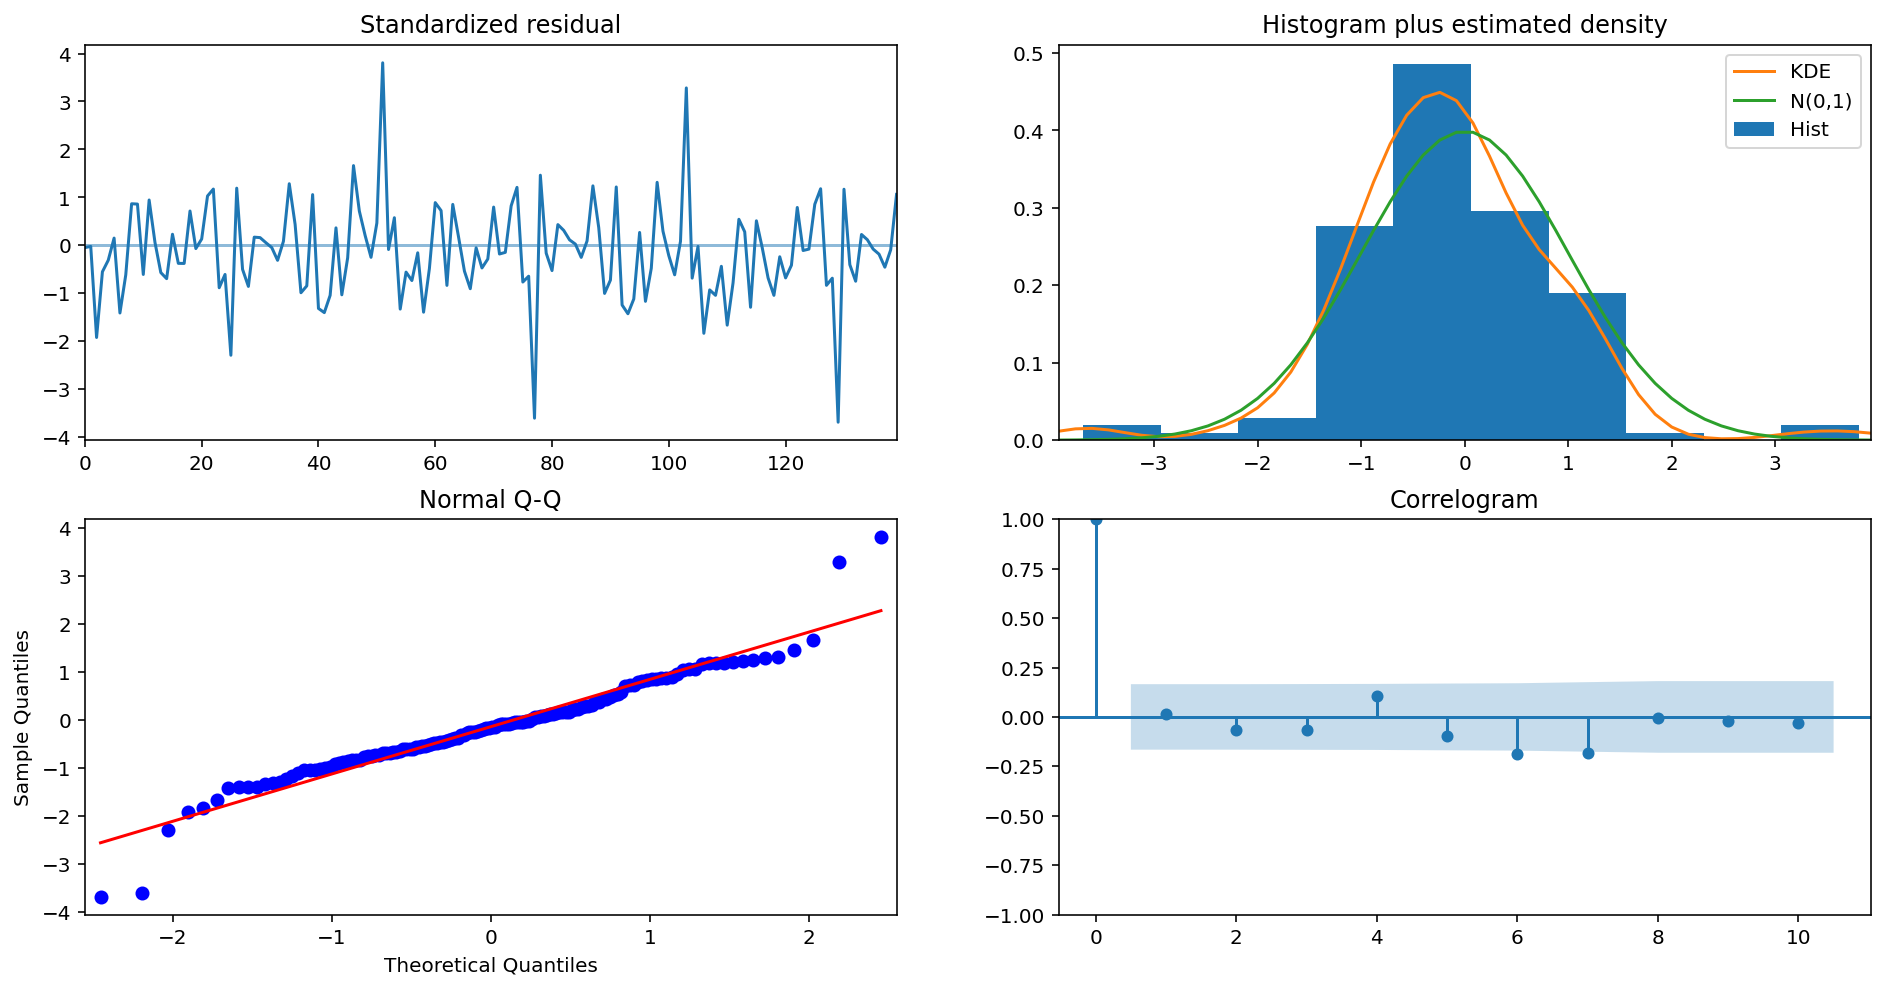

In [23]:
plt.rcParams.update({'figure.figsize':(16,8)})
model.plot_diagnostics()
plt.show()

## Accuracy Metrics for Time Series Predictions

In [24]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast - actual)[1]            # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, corn_data_test['value'].values)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


{'mape': 0.27268379847979485,
 'me': 0.5680716813984448,
 'mae': 0.5680716813984448,
 'mpe': 0.27268379847979485,
 'rmse': 0.5802499345589253,
 'acf1': 0.4694610772372987,
 'corr': -0.5167589580883599,
 'minmax': 0.21209958727306066}

## Use best ARIMA model to compute predictions

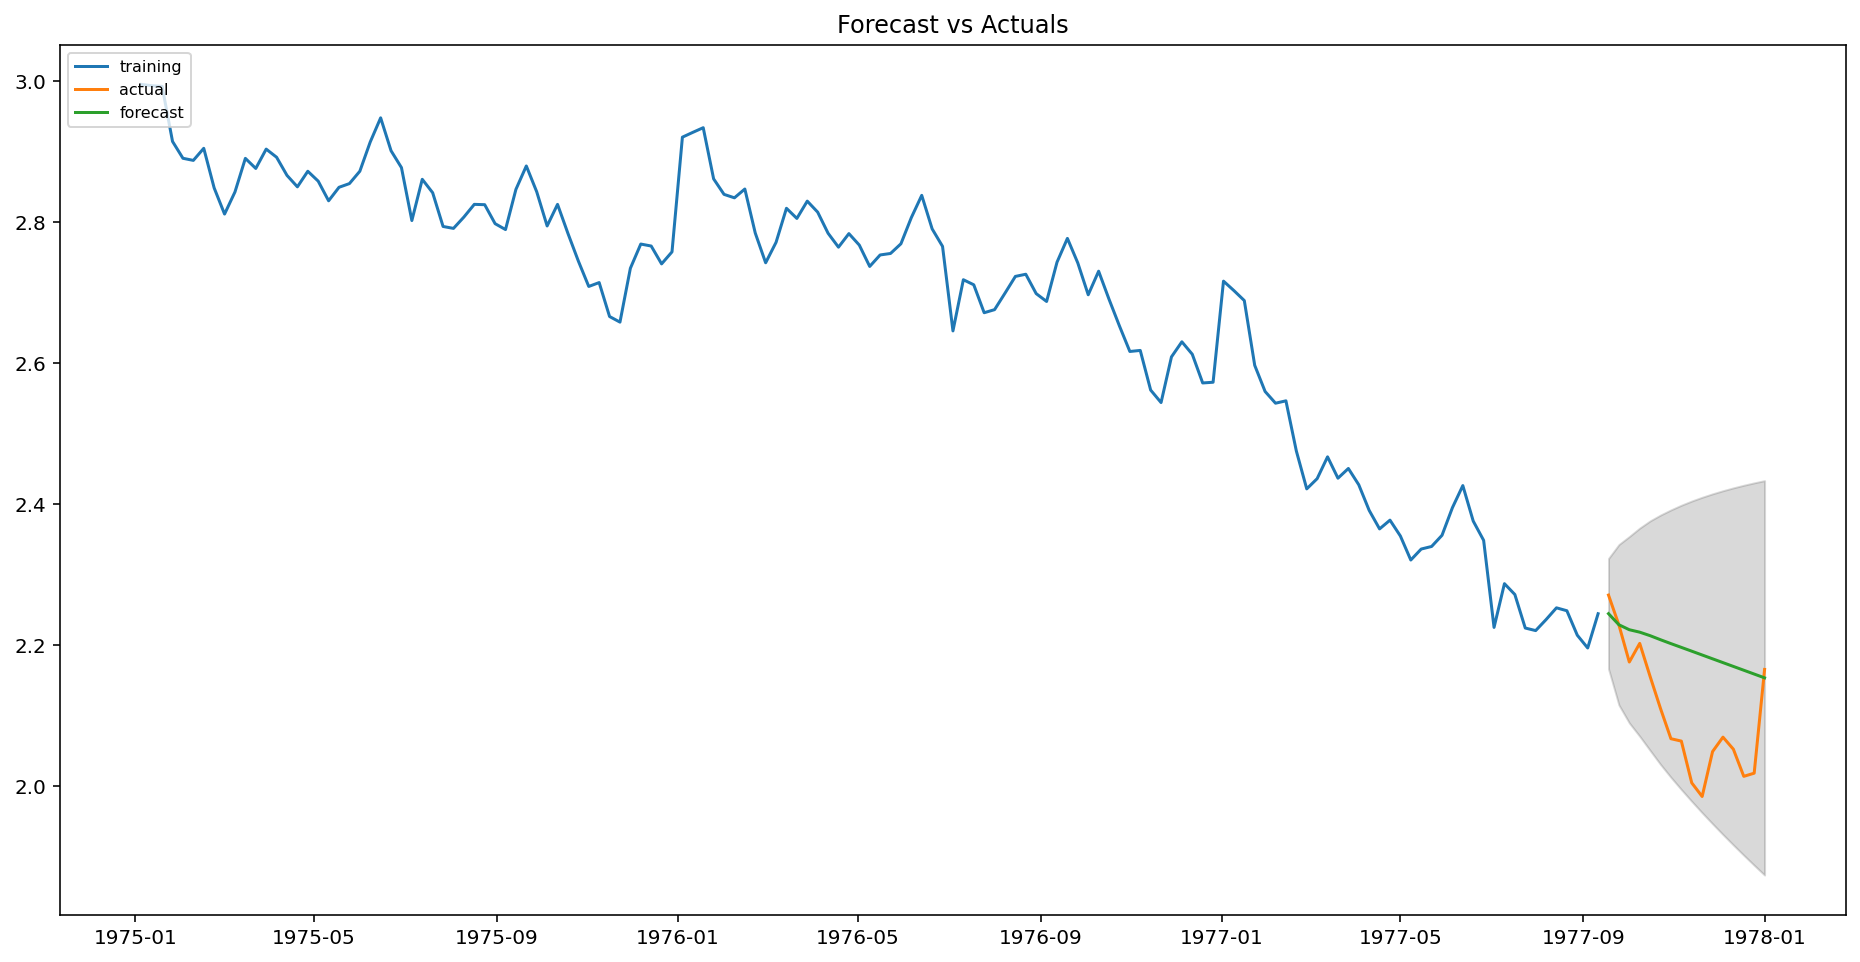

In [25]:
model = ARIMA(corn_data_train['value'].dropna().values, order=(2, 1, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(corn_data_test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=corn_data_test['value'].index)
lower_series = pd.Series(conf[:, 0], index=corn_data_test['value'].index)
upper_series = pd.Series(conf[:, 1], index=corn_data_test['value'].index)

# Plot
plt.plot(corn_data_train['value'], label='training')
plt.plot(corn_data_test['value'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Implement Seasonality Analysis
Compute differentiation with respect to the previous season values.

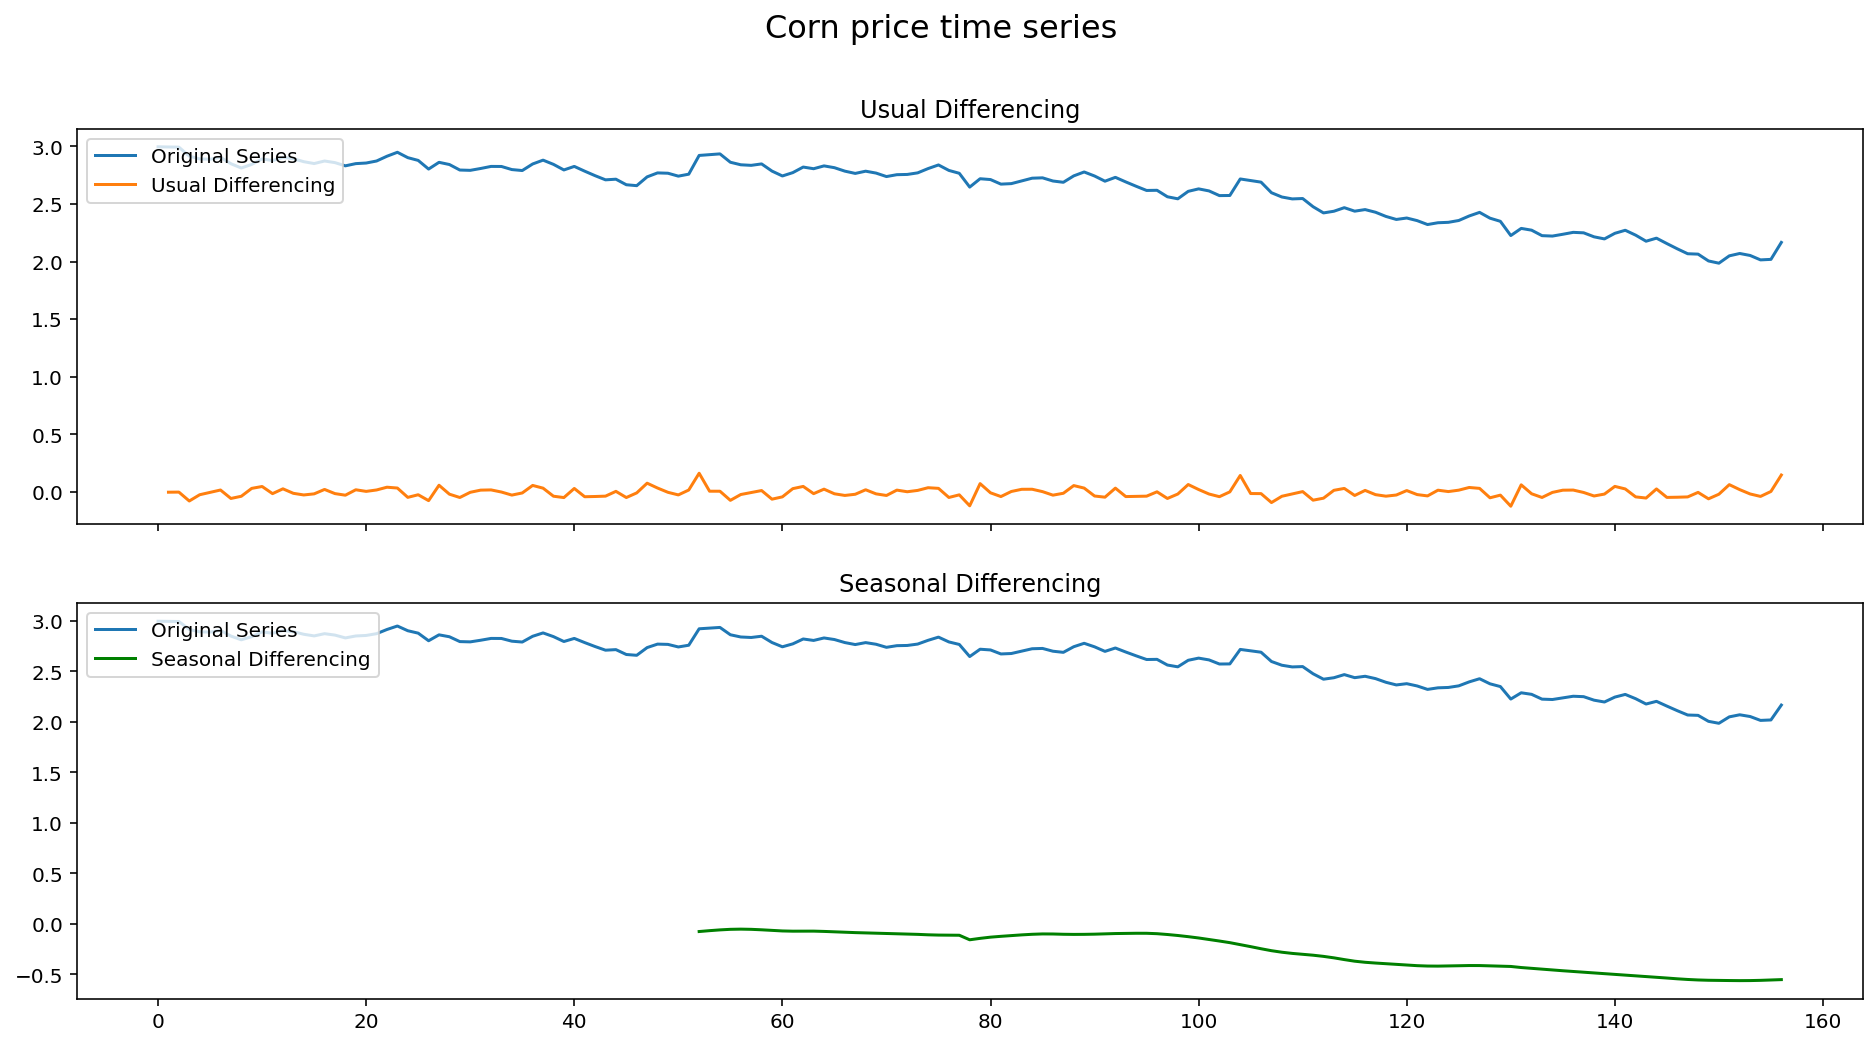

In [26]:
# Seasonal period: year
diff_factor = resample_period

# Plot
fig, axes = plt.subplots(2, 1, sharex=True)

# Usual Differencing
axes[0].plot(corn_data_clean['value'].values, label='Original Series')
axes[0].plot(corn_data_clean['value'].diff(1).values, label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Dei
axes[1].plot(corn_data_clean['value'].values, label='Original Series')
axes[1].plot(corn_data_clean['value'].diff(diff_factor).values, label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Corn price time series', fontsize=16)
plt.show()

In [27]:
smodel = pm.auto_arima(corn_data_train['value'].dropna().values, start_p=0, start_q=0,
                         test='adf',
                         max_p=5, max_q=5, m=diff_factor,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,1)[52]             : AIC=-585.799, Time=7.99 sec
 ARIMA(0,2,0)(0,1,0)[52]             : AIC=-587.794, Time=0.90 sec
 ARIMA(1,2,0)(1,1,0)[52]             : AIC=-602.571, Time=6.49 sec
 ARIMA(0,2,1)(0,1,1)[52]             : AIC=-610.171, Time=8.88 sec
 ARIMA(0,2,1)(0,1,0)[52]             : AIC=nan, Time=1.27 sec
 ARIMA(0,2,1)(1,1,1)[52]             : AIC=-608.170, Time=11.72 sec
 ARIMA(0,2,1)(0,1,2)[52]             : AIC=-608.171, Time=25.48 sec
 ARIMA(0,2,1)(1,1,0)[52]             : AIC=-611.370, Time=11.70 sec
 ARIMA(0,2,1)(2,1,0)[52]             : AIC=-608.171, Time=25.00 sec
 ARIMA(0,2,1)(2,1,1)[52]             : AIC=-606.171, Time=37.53 sec
 ARIMA(0,2,0)(1,1,0)[52]             : AIC=-586.600, Time=4.36 sec
 ARIMA(1,2,1)(1,1,0)[52]             : AIC=-609.514, Time=9.90 sec
 ARIMA(0,2,2)(1,1,0)[52]             : AIC=-609.522, Time=7.72 sec
 ARIMA(1,2,2)(1,1,0)[52]             : AIC=-599.842, Time=15.55 sec
 ARIMA(0,2,1)(1,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  141
Model:             SARIMAX(0, 2, 1)x(1, 1, [], 52)   Log Likelihood                 308.685
Date:                             Tue, 05 Apr 2022   AIC                           -611.370
Time:                                     17:01:10   BIC                           -603.973
Sample:                                          0   HQIC                          -608.392
                                             - 141                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5839      0.040    -14.420      0.000      -0.663      -0.505
ar.S.L52      -0.0841      0.155     -0.543      0.587      -0.388       0.220
sigma2      4.803e-05   2.87e-06     16.722      0.000    4.24e-05    5.37e-05
===================================================================================
Ljung-Box (Q):                       12.58   Jarque-Bera (JB):              1583.36
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

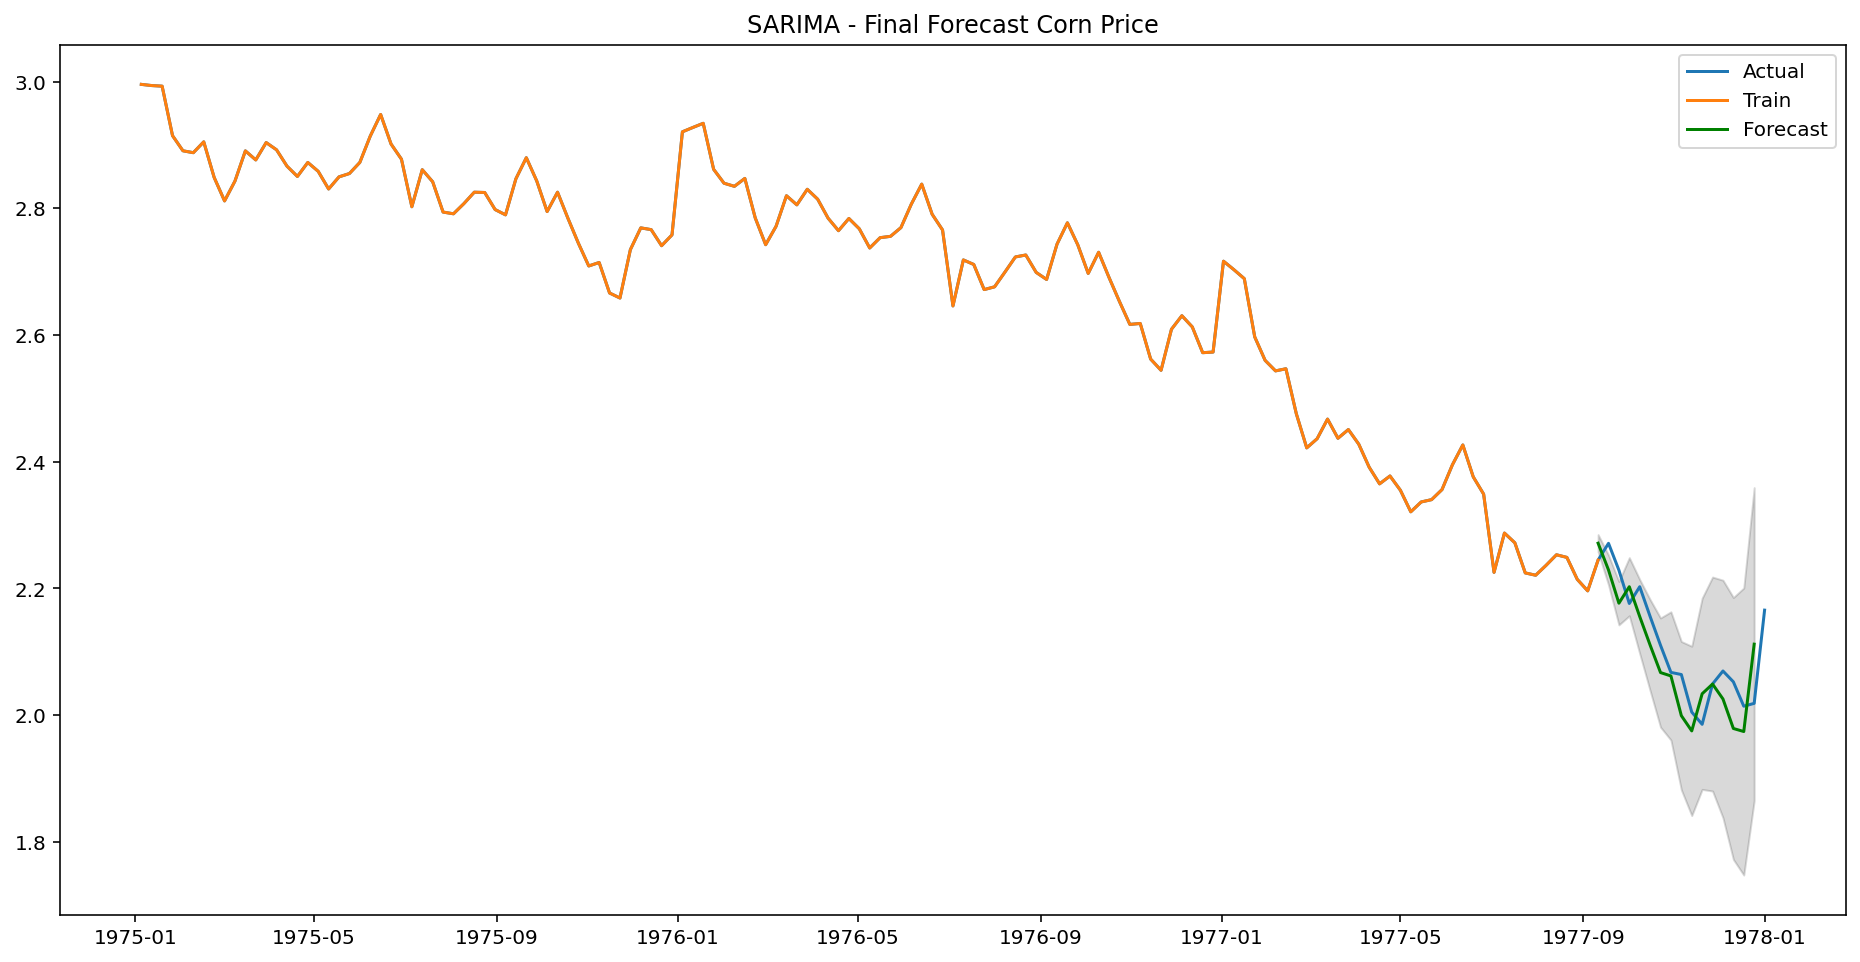

In [28]:
# Forecast
n_periods = len(corn_data_test) 
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(corn_data_train.index[-1], periods = n_periods, freq=resample_label)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(corn_data_clean, label='Actual')
plt.plot(corn_data_train, label='Train')
plt.plot(fitted_series, color='green', label='Forecast')
#Confidence intervals
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend()

plt.title("SARIMA - Final Forecast Corn Price")
plt.show()

### Decomposition